# 1.) Import the Credit Card Fraud Data From CCLE

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/fraudTest.csv')

In [4]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


# 2.) Select four columns to use as features (one just be trans_date_trans)

In [5]:
df_select = df[['trans_date_trans_time', 'category', 'amt', 'city_pop', 'is_fraud']]

In [6]:
df_select.head()

,trans_date_trans_time,category,amt,city_pop,is_fraud
0,2020-06-21 12:14:25,personal_care,2.86,333497,0
1,2020-06-21 12:14:33,personal_care,29.84,302,0
2,2020-06-21 12:14:53,health_fitness,41.28,34496,0
3,2020-06-21 12:15:15,misc_pos,60.05,54767,0
4,2020-06-21 12:15:17,travel,3.19,1126,0


# 3.) Create a unique variable out of trans_date.

In [7]:
df_select['trans_date_trans_time'] = pd.to_datetime(df_select['trans_date_trans_time'])

In [8]:
df_select['time_var'] = [i.second for i in df_select['trans_date_trans_time']]

In [9]:
dummies = pd.get_dummies(df_select['category'])
X = pd.concat([dummies, df_select[['amt', 'city_pop', 'time_var']]], axis = 1)
y = df_select['is_fraud']

In [10]:
X.head()

,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel,amt,city_pop,time_var
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.86,333497,25
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,29.84,302,33
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,41.28,34496,53
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,60.05,54767,15
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.19,1126,17


# 4.) Oversample the data (this will be your training data).

In [11]:
ros = RandomOverSampler(random_state = 0)
X_resampled, y_resampled = ros.fit_resample(X, y)

# 5.) Train a Logistic regression.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

In [13]:
log_reg = LogisticRegression().fit(X_train, y_train)

In [14]:
y_pred = log_reg.predict(X_test)

In [15]:
print('Accuracy:', log_reg.score(X_test, y_test))

Accuracy: 0.7844104231585602


# 6.) The company you are working for wants to target at a False Positive rate of 5% what threshold should you use? (Use oversampled data)

In [16]:
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

threshold_test = [(i+1)/1000 for i in range(1000)]
thershold_list = []
false_negative_rate_list = []

for threshold in threshold_test:
  y_pred = (y_pred_proba > threshold).astype(int)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  false_negative_rate = fn / (fn + tp)
  if false_negative_rate <= 0.05:
    thershold_list.append(threshold)
    false_negative_rate_list.append(false_negative_rate)

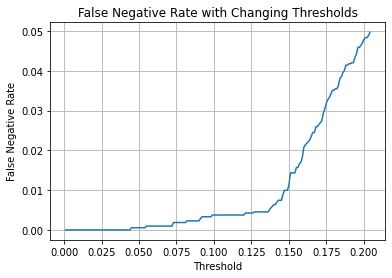

In [17]:
plt.plot(thershold_list, false_negative_rate_list)
plt.title('False Negative Rate with Changing Thresholds')
plt.xlabel('Threshold')
plt.ylabel('False Negative Rate')
plt.grid()
plt.show()

From the result above, we can find the critical value for the threshold is 0.204.

# 7.) If the company makes .02*amt on True transactions and loses -amt on False (Use original data)

In [18]:
thershold_list[-1]

0.204

In [19]:
y_pred_proba_or = log_reg.predict_proba(X)[:, 1]
y_pred_or = (y_pred_proba_or > 0.204).astype(int)

In [20]:
df_select['predictions'] = y_pred_or

df_select_t = df_select[df_select["is_fraud"] == df_select["predictions"]].copy()
df_select_f = df_select[df_select["is_fraud"] != df_select["predictions"]].copy()

df_select_t['Profit'] = 0.02 * df_select_t["amt"]
df_select_f['Profit'] = -1 * df_select_f["amt"]

profit = df_select_t['Profit'].sum() + df_select_f['Profit'].sum()
profit

-35072111.00600001

# 8.) Using Logistic Regression Lasso to inform you. Would you use the selected features in a trusted prediction model?

In [21]:
log_res_Lasso = LogisticRegression("l1", solver = 'liblinear')
log_res_Lasso.fit(X_train, y_train)
log_res_Lasso.coef_

array([[-2.95010431e+00, -1.20137144e+00, -1.48991886e-01,
        -3.46232591e-01, -1.01117107e+00, -8.65666805e-01,
        -1.83121011e+00, -9.56244993e-01, -3.75367161e+00,
        -7.57250233e-01, -5.90264976e-01, -4.93565811e+00,
        -4.74363889e+00, -2.02677288e-01,  1.06372913e-02,
        -5.42030882e-07,  1.35907249e-03]])

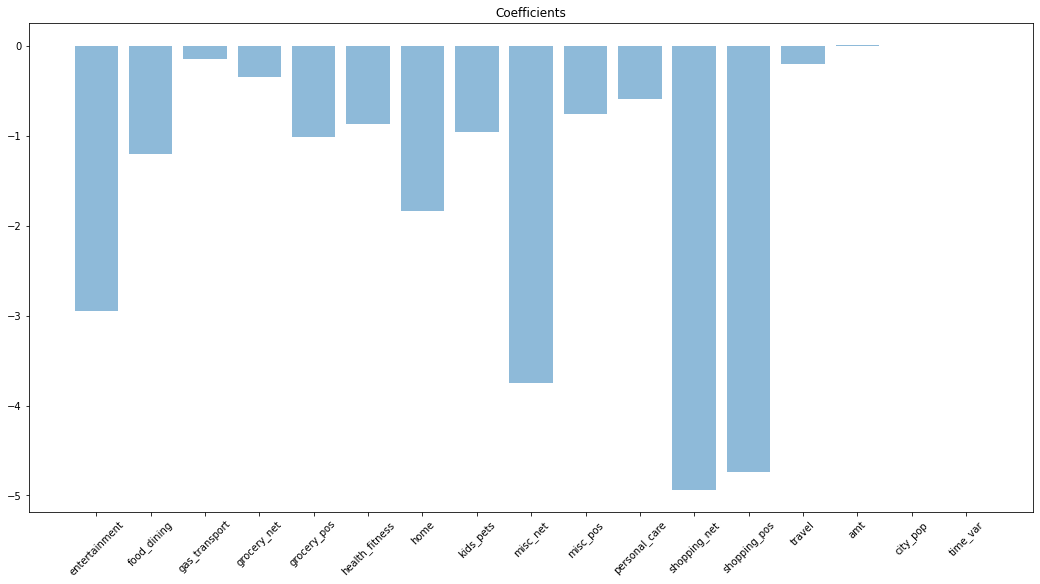

In [22]:
objects = list(X_train.columns)
plt.figure(figsize = (18, 9))
plt.bar(objects, log_res_Lasso.coef_[0], align='center', alpha = 0.5)
plt.xticks(objects, rotation=45)
plt.title('Coefficients')
plt.show()

From the coeefficients of Lasso model, most of the dummies generated from *'category'* are significantly different from 0, which means it is a suitable predictor for the model. However, *'amt'* has only subtle influence and *'city_pop'* and *'time_car*' has no influence under the punishment from Lasso. Therefore, these 3 predictors should be replaced or eliminated.